### Understanding data

In [2]:
import pandas as pd

In [3]:
housing = pd.read_csv('./housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
print(housing['ocean_proximity'].value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


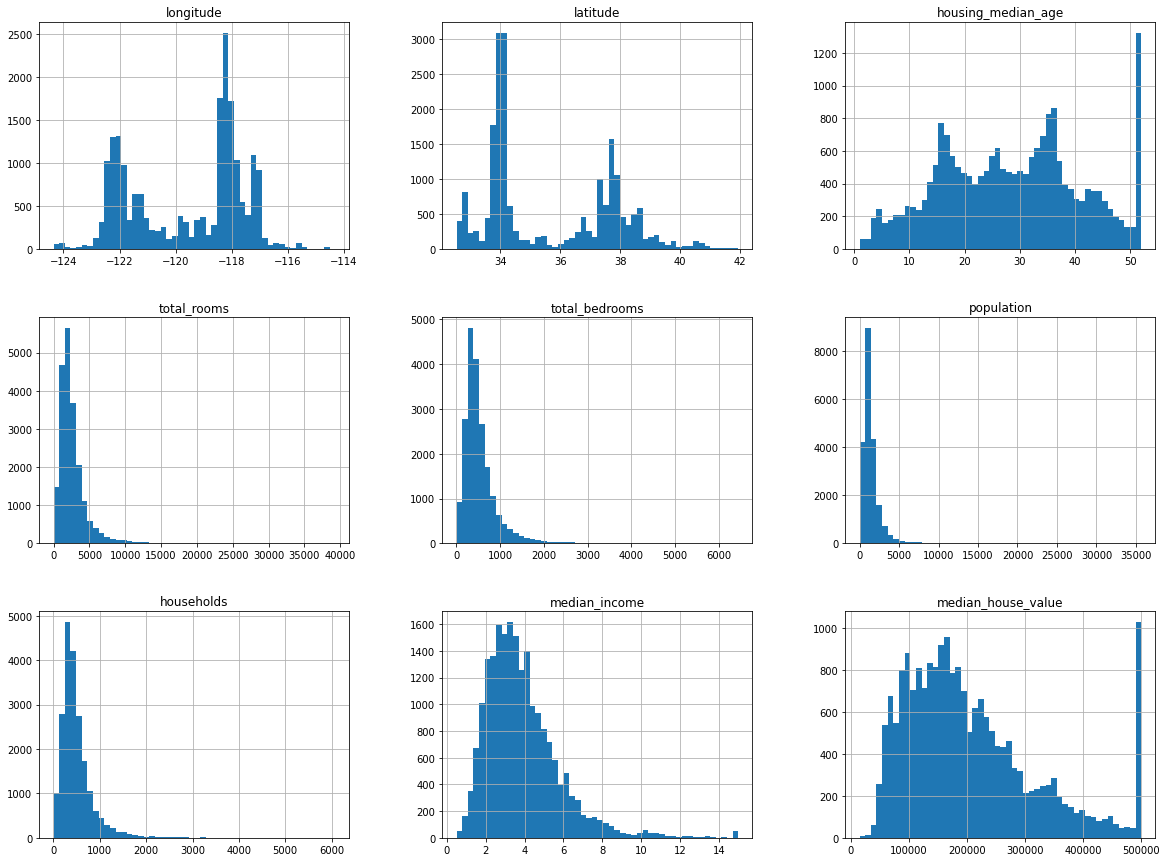

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Creating Test set

###### Approach 1  -- randomly selecting data

In [8]:
import numpy as np
def split_train_test(data, test_ratio):
     shuffled_indices = np.random.permutation(len(data))
     test_set_size = int(len(data) * test_ratio)
     test_indices = shuffled_indices[:test_set_size]
     train_indices = shuffled_indices[test_set_size:]
     return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)

In [10]:
print(len(train_set))

16512


In [11]:
print(len(test_set))

4128


This is not a good approach because if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

##### Approach 2  -- using hash function

> A common solution is to use each instance’s identifier to decide whether or not it should goin the test set (assuming instances have a unique and immutable identifier). 

> For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. 

>This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set. Here is a possible implementation:

In [12]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier.


In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

##### Approach 3 -- scikit-learn built in method

> Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

##### Approach 4 -- Stratified Sampling

> So far we have considered purely random sampling methods. This is generally fine if
your dataset is large enough (especially relative to the number of attributes), but if it
is not, you run the risk of introducing a significant **sampling bias**. 

> When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick
1,000 people randomly in a phone book. They try to ensure that these 1,000 people
are representative of the whole population. 

> For example, the US population is com‐
posed of 51.3% female and 48.7% male, so a well-conducted survey in the US would
try to maintain this ratio in the sample: 513 female and 487 male. This is called **stratified sampling**: the population is divided into homogeneous subgroups called strata,
and the right number of instances is sampled from each stratum to guarantee that the
test set is representative of the overall population.

> Suppose you chatted with experts who told you that the median income is a very
important attribute to predict median housing prices. You may want to ensure that
the test set is representative of the various categories of incomes in the whole dataset.
Since the median income is a continuous numerical attribute, you first need to create
an income category attribute.

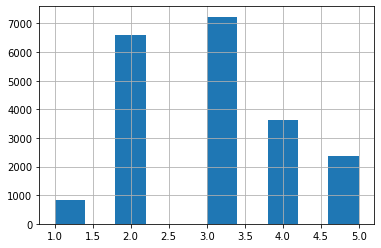

In [16]:
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()
plt.show()

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s StratifiedShuffleSplit class:

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [18]:
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


In [19]:
strat_test_set.drop("income_cat", axis=1, inplace=True)
strat_train_set.drop("income_cat", axis=1, inplace=True)

### Discover and Visualize the Data to Gain Insights

if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can
just work directly on the full set. Let’s create a copy so you can play with it without harming the training set:

In [20]:
housing = strat_train_set.copy()

###### Visualizing Geographical Data
Since there is geographical information (latitude and longitude), it is a good idea to
create a scatterplot of all districts to visualize the data

In [21]:
%config InlineBackend.figure_format ='retina'

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

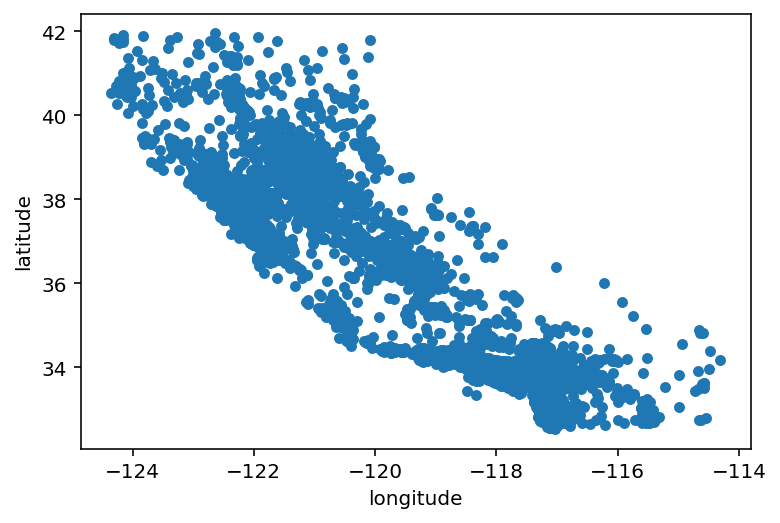

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude")

This looks like California all right, but other than that it is hard to see any particular
pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places
where there is a high density of data points

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

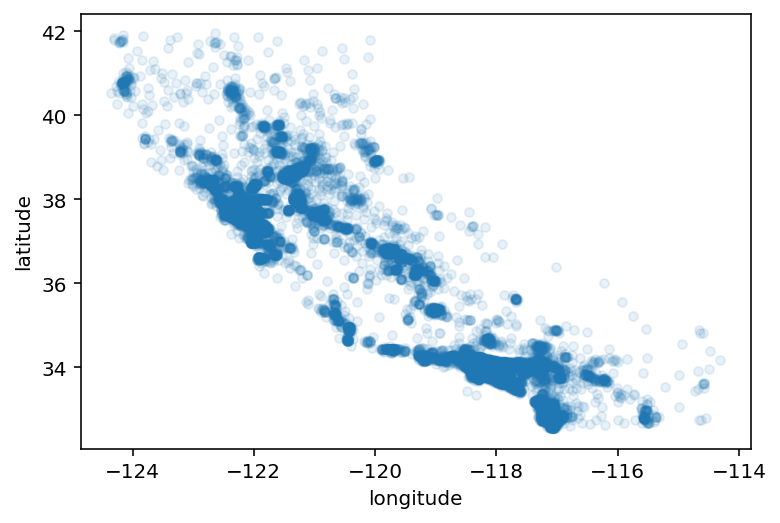

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

The radius of each circle represents
the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices):

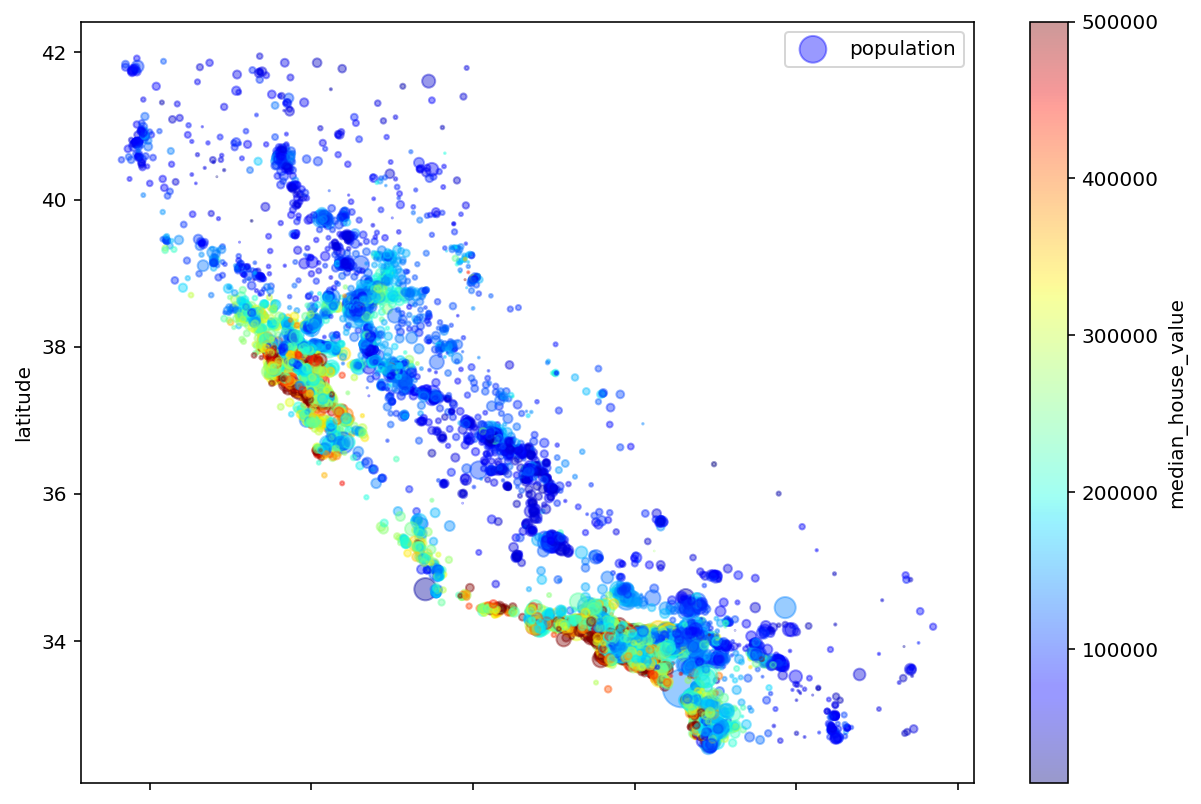

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density, as you probably knew already.
It will probably be useful to use a clustering algorithm to detect the main clusters, and
add new features that measure the proximity to the cluster centers. The ocean prox‐
imity attribute may be useful as well, although in Northern California the housing
prices in coastal districts are not too high, so it is not a simple rule.

##### Looking for Correlations

In [25]:
corr_matrix = housing.corr()

In [26]:
print(corr_matrix['median_house_value'].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


Another way to check for correlation between attributes is to use Pandas’
scatter_matrix function, which plots every numerical attribute against every other
numerical attribute. Since there are now 11 numerical attributes, you would get 112 =
121 plots, which would not fit on a page, so let’s just focus on a few promising
attributes that seem most correlated with the median housing value

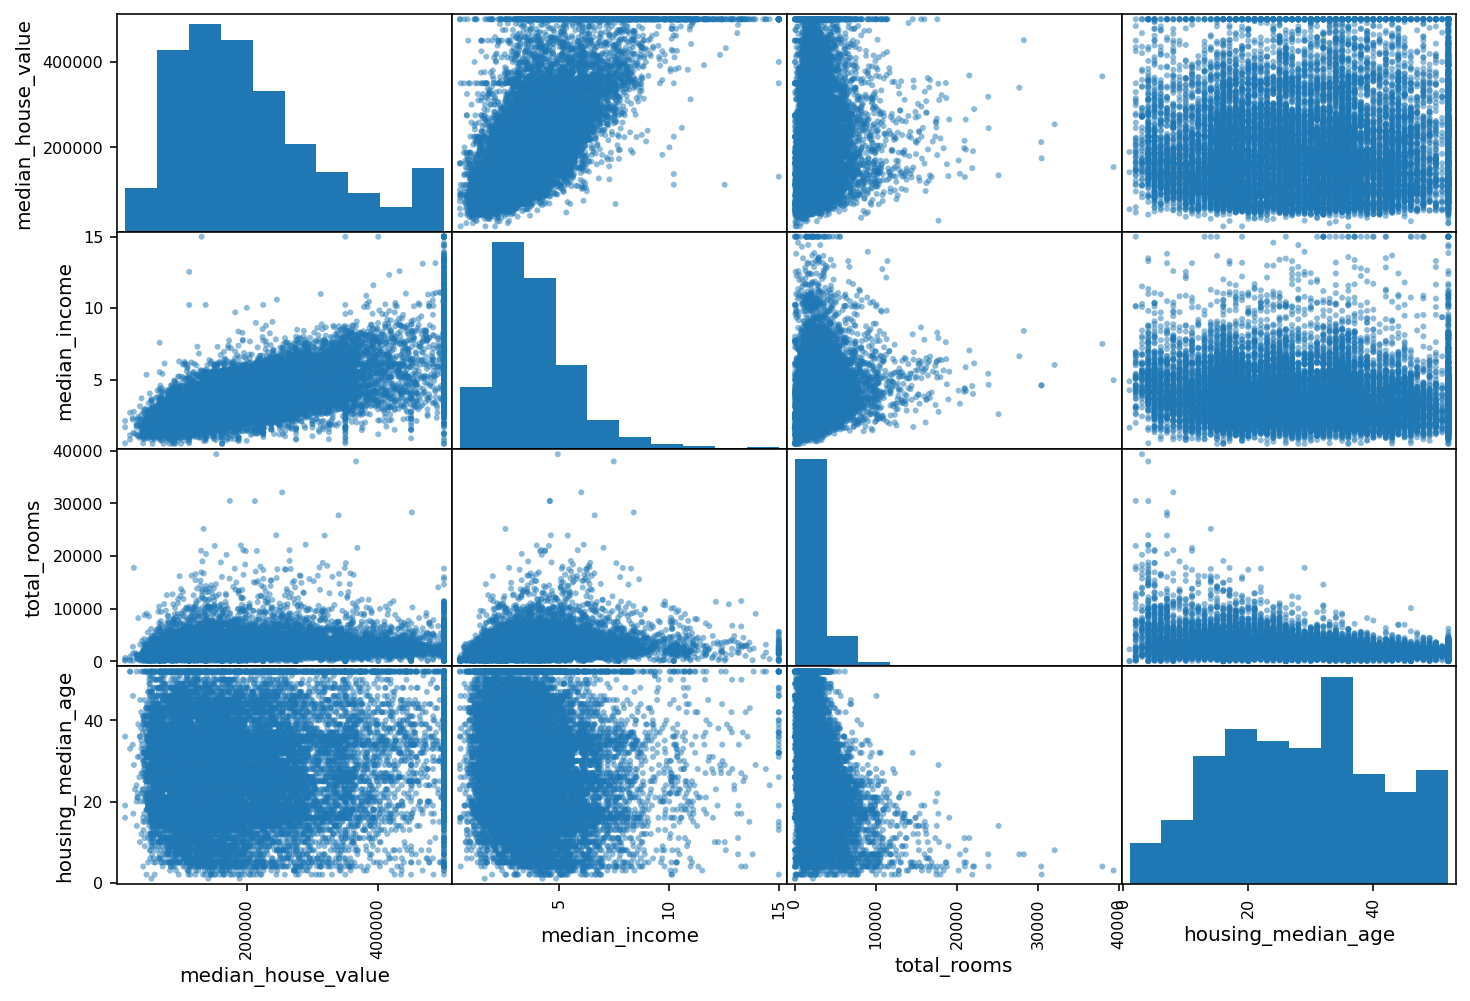

In [27]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

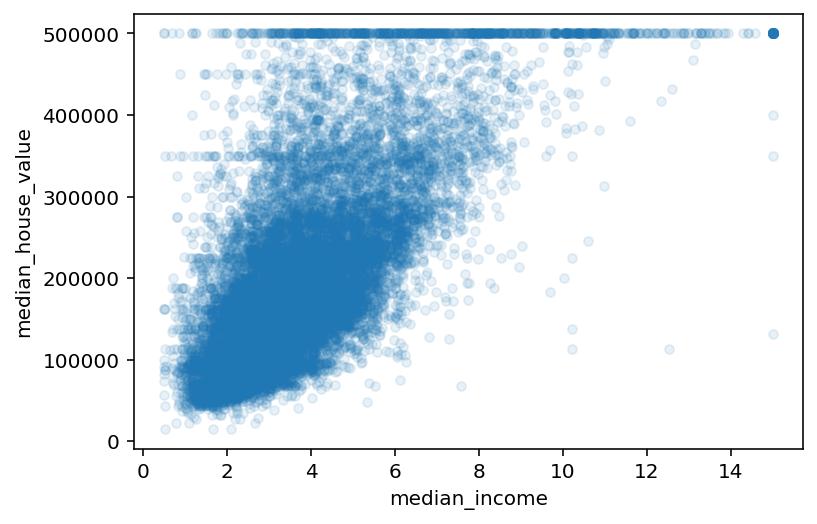

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)
plt.show()

> This plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend and the points are not too dispersed. 

> Second, the price
cap that we noticed earlier is clearly visible as a horizontal line at 500,000. But this
plot reveals other less obvious straight lines: a horizontal line around 450,000,
another around 350,000, perhaps one around 280,000, and a few more below that.

> You may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks

##### Calculating some attributes

> The total number of rooms in a district is not very useful if you don’t know how many
households there are. What you really want is the number of rooms per household.

> The total number of bedrooms by itself is not very useful: you probably
want to compare it to the number of rooms. 

>And the population per household also
seems like an interesting attribute combination to look at. Let’s create these new
attributes:

In [29]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

### Prepare the Data for Machine Learning Algorithms

Let’s separate the predictors and the labels since we don’t necessarily want to apply
the same transformations to the predictors and the target values (note that drop()
creates a copy of the data and does not affect strat_train_set):


In [31]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

##### Data Cleaning

You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:
> Get rid of the corresponding districts.

> Get rid of the whole attribute.

> Set the values to some value (zero, the mean, the median, etc.).

In [32]:
housing.dropna(subset=["total_bedrooms"]) # option 1

housing.drop("total_bedrooms", axis=1) # option 2

median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

Scikit-Learn provides a handy class to take care of missing values: SimpleImputer.
Here is how to use it. First, you need to create a SimpleImputer instance, specifying
that you want to replace each attribute’s missing values with the median of that
attribute:

In [33]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, we need to create a
copy of the data without the text attribute ocean_proximity:

In [37]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result
in its statistics_ instance variable. Only the total_bedrooms attribute had missing
values, but we cannot be sure that there won’t be any missing values in new data after
the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [39]:
 housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [40]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

###### Handling Text and Categorical Attributes

Most Machine Learning algorithms prefer to work with numbers anyway, so let’s con‐
vert these categories from text to numbers. For this, we can use Scikit-Learn’s Ordina
lEncoder class:

In [42]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [43]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [44]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

> One issue with this representation is that ML algorithms will assume that two nearby
values are more similar than two distant values. This may be fine in some cases (e.g.,
for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously
not the case for the ocean_proximity column (for example, categories 0 and 4 are
clearly more similar than categories 0 and 1). 

> To fix this issue, a common solution is
to create one binary attribute per category: one attribute equal to 1 when the category
is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is
“INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because
only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new
attributes are sometimes called dummy attributes.

In [45]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

> After one hot encoding we get a matrix with thousands of columns, and the matrix is full of
zeros except for a single 1 per row. Using up tons of memory mostly to store zeros
would be very wasteful, so instead a sparse matrix only stores the location of the non‐zero elements. 

> You can use it mostly like a normal 2D array,21 but if you really want to
convert it to a (dense) NumPy array, just call the toarray() method:

In [46]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

###### Custom Transformers

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
         self.add_bedrooms_per_room = add_bedrooms_per_room
     
    def fit(self, X, y=None):
         return self # nothing else to do
     
    def transform(self, X, y=None):
         rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
         population_per_household = X[:, population_ix] / X[:, households_ix]
         if self.add_bedrooms_per_room:
             bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
             return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
         else:
             return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


###### Feature Scaling

> Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales. This is the case for the hous‐
ing data: the total number of rooms ranges from about 6 to 39,320, while the median
incomes only range from 0 to 15. 

> There are two common ways to get all attributes to have the same scale: **min-max
scaling** and **standardization**.

> Min-max scaling (many people call this normalization) is quite simple: values are
shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtract‐
ing the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called **MinMaxScaler** for this. It has a **feature_range** hyperparameter
that lets you change the range if you don’t want 0–1 for some reason.


> Standardization is quite different: first it subtracts the mean value (so standardized
values always have a zero mean), and then it divides by the standard deviation so that
the resulting distribution has unit variance. 

> Unlike min-max scaling, standardization
does not bound values to a specific range, which may be a problem for some algo‐
rithms (e.g., neural networks often expect an input value ranging from 0 to 1). 

>However, standardization is much less affected by outliers. For example, suppose a district
had a median income equal to 100 (by mistake). Min-max scaling would then crush
all the other values from 0–15 down to 0–0.15, whereas standardization would not be
much affected. Scikit-Learn provides a transformer called **StandardScaler** for stand‐
ardization.

> **As with all the transformations, it is important to fit the scalers to
the training data only, not to the full dataset (including the test set).
Only then can you use them to transform the training set and the
test set (and new data).**

##### Transformation Pipelines

 Scikit-Learn provides the Pipeline class to help with
such sequences of transformations. Here is a small pipeline for the numerical
attributes:

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler()),
 ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns sepa‐
rately. It would be more convenient to have a single transformer able to handle all col‐
umns, applying the appropriate transformations to each column. 

In version 0.20,
Scikit-Learn introduced the ColumnTransformer for this purpose, and the good news
is that it works great with Pandas DataFrames. Let’s use it to apply all the transforma‐
tions to the housing data:

In [51]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])

housing_prepared = full_pipeline.fit_transform(housing)

Note that the OneHotEncoder returns a sparse matrix, while the num_pipeline returns
a dense matrix. When there is such a mix of sparse and dense matrices, the Colum
nTransformer estimates the density of the final matrix (i.e., the ratio of non-zero
cells), and it returns a sparse matrix if the density is lower than a given threshold (by
default, sparse_threshold=0.3). In this example, it returns a dense matrix.

### Select and Train a Model

In [52]:
housing_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [54]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [55]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


###### measure error

In [56]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

> This is better than nothing but clearly not a great score: most districts’
median_housing_values range between 120,000 and 265,000, so a typical predic‐
tion error of 68,628 is not very satisfying. 

> This is an example of a model underfitting
the training data. When this happens it can mean that the features do not provide
enough information to make good predictions, or that the model is not powerful
enough. let’s try a more complex model to see how it does

In [57]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [58]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

##### Better Evaluation Using Cross-Validation

Use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it
trains and evaluates the Decision Tree model 10 times, picking a different fold for
evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:


In [59]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [60]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [73672.9677143  70491.16116119 69369.49982376 73727.84403217
 70596.93792063 76366.24687381 70699.32547554 73206.76064351
 68620.24315288 71774.13634709]
Mean: 71852.51231448803
Standard deviation: 2245.380965087413


> Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to per‐
form worse than the Linear Regression model! 

> Notice that cross-validation allows
you to get not only an estimate of the performance of your model, but also a measure
of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a
score of approximately 71,407, generally ±2,439. You would not have this information
if you just used one validation set

In [62]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180675


**Decision Tree** model is overfitting so badly that it performs worse
than the **Linear Regression** model. Lets Try **Random Forrest**

In [63]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [66]:
rf_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

Scores: [51283.08706926 48879.57107814 46616.66502001 52099.16293127
 47515.66895322 51856.9481491  52517.83638571 49717.69437133
 48347.03844695 53761.22861514]
Mean: 50259.49010201493
Standard deviation: 2258.3232533780356


Random Forests look very promising. However, note that
the score on the training set is still much lower than on the validation sets, meaning
that the model is still overfitting the training set. Possible solutions for overfitting are
to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

##### Saving the model

In [68]:
import joblib
joblib.dump(forest_reg, "forest_reg.pkl")
# and later...
forest_reg = joblib.load("forest_reg.pkl")

### Fine-Tune Your Model

**Grid Search** ->
One way to do that would be to fiddle with the hyperparameters manually, until you
find a great combination of hyperparameter values. This would be very tedious work,
and you may not have time to explore many combinations.
Instead you should get Scikit-Learn’s GridSearchCV to search for you

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [30, 40, 45, 50, 60], 'max_features': [8, 10, 12, 14]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [8, 10, 12, 14],
                          'n_estimators': [30, 40, 45, 50, 60]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [76]:
 grid_search.best_params_

{'max_features': 10, 'n_estimators': 50}

In [77]:
grid_search.best_estimator_

RandomForestRegressor(max_features=10, n_estimators=50)

And of course the evaluation scores are also available:

In [78]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50103.77412425499 {'max_features': 8, 'n_estimators': 30}
49803.2693779465 {'max_features': 8, 'n_estimators': 40}
49727.92928604815 {'max_features': 8, 'n_estimators': 45}
49817.31741527636 {'max_features': 8, 'n_estimators': 50}
49736.39886714036 {'max_features': 8, 'n_estimators': 60}
50362.088084499446 {'max_features': 10, 'n_estimators': 30}
49776.77501316632 {'max_features': 10, 'n_estimators': 40}
50008.64788835639 {'max_features': 10, 'n_estimators': 45}
49623.63348119493 {'max_features': 10, 'n_estimators': 50}
49904.81242047739 {'max_features': 10, 'n_estimators': 60}
50619.017502683106 {'max_features': 12, 'n_estimators': 30}
50389.07221490375 {'max_features': 12, 'n_estimators': 40}
50254.61487475884 {'max_features': 12, 'n_estimators': 45}
50243.04682817203 {'max_features': 12, 'n_estimators': 50}
50139.075921544354 {'max_features': 12, 'n_estimators': 60}
51025.012065556446 {'max_features': 14, 'n_estimators': 30}
50778.11618629085 {'max_features': 14, 'n_estimators': 40}

**Randomized Search** -> The grid search approach is fine when you are exploring relatively few combinations,
like in the previous example, but when the hyperparameter search space is large, it is
often preferable to use RandomizedSearchCV instead. This class can be used in much
the same way as the GridSearchCV class, but instead of trying out all possible combi‐
nations, it evaluates a given number of random combinations by selecting a random
value for each hyperparameter at every iteration. 

This approach has two main benifits:

>If you let the randomized search run for, say, 1,000 iterations, this approach will
explore 1,000 different values for each hyperparameter (instead of just a few val‐
ues per hyperparameter with the grid search approach).

>You have more control over the computing budget you want to allocate to hyper‐
parameter search, simply by setting the number of iterations.

### Analyze the Best Models and Their Errors

In [79]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [80]:
feature_importances

array([6.77723827e-02, 5.94665930e-02, 4.32245857e-02, 1.39365541e-02,
       1.41474718e-02, 1.35550013e-02, 1.34243459e-02, 4.02957437e-01,
       4.70541251e-02, 1.10213977e-01, 3.76706626e-02, 5.76011857e-03,
       1.66439071e-01, 1.28193213e-04, 1.56273749e-03, 2.68674246e-03])

In [81]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.4029574373423188, 'median_income'),
 (0.16643907139430364, 'INLAND'),
 (0.11021397736092822, 'pop_per_hhold'),
 (0.06777238272825471, 'longitude'),
 (0.0594665929708828, 'latitude'),
 (0.04705412510132784, 'rooms_per_hhold'),
 (0.0432245856704769, 'housing_median_age'),
 (0.03767066258239142, 'bedrooms_per_room'),
 (0.014147471819562408, 'total_bedrooms'),
 (0.013936554095203644, 'total_rooms'),
 (0.013555001343982569, 'population'),
 (0.013424345856908111, 'households'),
 (0.005760118574403772, '<1H OCEAN'),
 (0.0026867424597820573, 'NEAR OCEAN'),
 (0.0015627374858733906, 'NEAR BAY'),
 (0.00012819321339976547, 'ISLAND')]

### Evaluate Your System on the Test Set

In [82]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47514.91864812062

In some cases, such a point estimate of the generalization error will not be quite
enough to convince you to launch: what if it is just 0.1% better than the model cur‐
rently in production? You might want to have an idea of how precise this estimate is.
For this, you can compute a 95% confidence interval for the generalization error using
scipy.stats.t.interval():

In [83]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))

array([45485.27126645, 49461.34941641])